<a href="https://colab.research.google.com/github/vadim-privalov/-/blob/main/%D0%A4%D0%B8%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Финальный проект. Решение задачи бинарной классификаци, сравнение классических линейных моделей и простейшей нейросети**

Вашему вниманию представлена задача по классификации совершенной транзакции , совершил ли ее сам клиент или его данными воспользовались мошенники.
В этом наборе данных представлены транзакции, которые произошли за два дня, из которых у нас 492 мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, на положительный класс (мошенничество) приходится 0,172% всех транзакций.

К сожалению, из-за проблем с конфиденциальностью данные зашифрованны. Характеристики V1, V2,… V28 - это основные компоненты нашего датасета, единственными функциями, которые не были преобразованы, являются «Время» и «Количество». Функция «Время» содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Функция «Сумма» - это сумма транзакции. Функция «Класс» - это переменная ответа, которая принимает значение 1 в случае мошенничества и 0 в противном случае.

Т.к. наш датасет большого размера (> 25Мб), то копируем его на Гугл диск, подключаем "Драйвер" связи ноутбука и диска и указываем путь к нашим данным

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!ls '/content/drive/MyDrive/creditcard.csv'

/content/drive/MyDrive/creditcard.csv


Импортируем необходимые нам для работы библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import warnings
pd.options.display.max_rows = 10
from imblearn.under_sampling import TomekLinks
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from random import sample
from sklearn.model_selection import cross_val_score, train_test_split
from  sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Загружаем наш датафрейм и открываем его

In [ ]:
df = pd.read_csv(filepath_or_buffer = "/content/drive/MyDrive/creditcard.csv",
                           sep = ',')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Имеем 31 столбец и 284 807 строк. Датафрейм большого размера и имеет смысл удалить из него данные, которые ни какого влияния на ожидаемый результат не окажут, а только в холостую будут расходовать вычислительные способности компьютера.
Т.к. мы однозначно не можем удалить данные V.....(мы просто не знаем что они подразумевают и какую роль играют), но вот данные "Time" на совершенно не нужны, поэтому просто удалим весь столбец

In [ ]:
del df['Time']
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Выводим статистику по нашим столбцам, для того, что бы попытаться оценить наши данные в первом приближении

In [ ]:
df.describe() 

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Видим, что значения по столбцу "Траты" имеют огромный разброс по данным

Вычисляем количество значений, отличных от NaN, по каждому столбцу, что бы исключить ошибки в дальнейшем

In [ ]:
df.count(axis=0) 

V1        284807
V2        284807
V3        284807
V4        284807
V5        284807
           ...  
V26       284807
V27       284807
V28       284807
Amount    284807
Class     284807
Length: 30, dtype: int64

У нас не NaТ, т.к. число значений отличных от NaN совпадает с общим числом строк

Посмотрим на типы данных наших столбцов:

In [ ]:
df.dtypes

V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
           ...   
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
Length: 30, dtype: object

Все данные нашего датафрейма имеют "цифровой" вид, т.е. нет категориальных данных и отпадает необходимость проводить кодировку.

Перемешиваем наш датафрейм

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.193084,-0.243758,0.561957,-0.209955,-0.693120,-0.273696,-0.494464,0.209129,0.374441,-0.041541,1.419469,0.145855,-1.575720,0.673876,0.978403,0.385308,-0.244837,-0.175877,-0.029708,-0.186006,-0.072166,-0.277424,0.131359,0.024091,-0.040186,0.922554,-0.068739,-0.007456,3.71,0
1,-1.240219,2.013396,-2.321258,-0.412685,2.220180,2.967957,-0.133021,1.413871,-0.080872,1.265909,-0.428342,0.037377,-0.015157,0.784527,0.868207,-0.153412,-0.445925,0.311998,0.629687,0.530891,-0.006985,0.220625,0.106532,0.987740,-0.322836,-0.404601,0.449316,0.118063,1.79,0
2,-1.961767,3.469548,-1.500783,-1.790021,-5.040713,2.142282,2.976389,1.157866,-0.624146,-1.006644,0.672782,0.570868,-0.540722,1.250220,-0.062395,1.235849,-0.167036,-0.320676,-0.531777,-1.569551,-0.598608,-0.212048,0.268637,-0.221158,-0.065224,0.821537,1.178380,-0.465724,936.39,0
3,0.693744,-0.643068,0.475474,1.454623,-0.576425,0.326848,-0.014558,0.215119,0.295230,-0.058278,1.025536,0.747069,-1.128102,0.404451,-0.509195,-0.248845,0.001323,-0.344058,-0.133271,0.191793,-0.074386,-0.572288,-0.114056,-0.022102,0.275464,-0.535655,0.004810,0.049279,219.00,0
4,-2.182027,2.482285,-3.152009,-1.415473,2.371989,4.421211,-2.141137,-5.087747,0.222486,-0.481496,0.018986,0.351313,-0.401255,-0.112674,0.955752,0.152653,1.013586,0.721959,-0.420471,-1.594451,6.427294,-1.197536,0.902768,0.520765,-0.139067,-0.086375,0.218757,0.057958,21.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-0.778130,-0.201358,1.596792,-3.262797,-1.407508,-0.936827,-0.665717,0.678594,2.681911,-2.753943,-0.600351,0.968960,-0.966167,-0.214924,0.053904,-0.639481,0.066798,0.038193,-1.177545,-0.501906,0.482971,1.584969,0.050449,0.643259,-0.871888,-1.086990,0.210853,0.164243,5.46,0
284803,-7.819015,6.264388,-2.294920,-2.188326,-0.792476,0.098886,0.365775,0.546057,5.651007,9.785595,1.211700,0.354027,-0.203375,-2.095251,1.062516,-0.294569,-1.169613,-0.428013,-0.494360,3.920202,-1.335329,-1.137555,0.177513,-1.298907,1.321332,0.119186,1.877881,0.587095,8.94,0
284804,-0.666302,0.893002,1.293501,-0.144367,0.260300,-0.456885,1.129313,-0.168345,-0.777460,-0.528327,0.026473,0.516356,0.851033,0.146745,0.872125,-0.230806,-0.099427,-1.257881,-0.080795,0.003075,-0.338540,-1.060097,0.217110,0.067619,-0.638580,-0.081554,-0.037182,0.143869,70.90,0
284805,-0.723709,1.010598,0.735294,1.035587,-0.457619,0.657858,0.233333,0.629807,0.146040,-0.305817,-0.372850,0.190452,-1.757897,0.459360,-1.494140,-0.461570,0.196839,0.149567,1.571796,-0.345075,-0.336031,-0.958200,0.185373,-0.506058,-0.866364,-1.018474,-0.102270,0.109922,68.90,0


Выделим целевую переменную в отдельный формат и удалим ее из обучающей выборки.

In [ ]:
y = np.array(df['Class'])
X = df.drop(['Class'], axis = 1)
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,1.193084,-0.243758,0.561957,-0.209955,-0.693120,-0.273696,-0.494464,0.209129,0.374441,-0.041541,1.419469,0.145855,-1.575720,0.673876,0.978403,0.385308,-0.244837,-0.175877,-0.029708,-0.186006,-0.072166,-0.277424,0.131359,0.024091,-0.040186,0.922554,-0.068739,-0.007456,3.71
1,-1.240219,2.013396,-2.321258,-0.412685,2.220180,2.967957,-0.133021,1.413871,-0.080872,1.265909,-0.428342,0.037377,-0.015157,0.784527,0.868207,-0.153412,-0.445925,0.311998,0.629687,0.530891,-0.006985,0.220625,0.106532,0.987740,-0.322836,-0.404601,0.449316,0.118063,1.79
2,-1.961767,3.469548,-1.500783,-1.790021,-5.040713,2.142282,2.976389,1.157866,-0.624146,-1.006644,0.672782,0.570868,-0.540722,1.250220,-0.062395,1.235849,-0.167036,-0.320676,-0.531777,-1.569551,-0.598608,-0.212048,0.268637,-0.221158,-0.065224,0.821537,1.178380,-0.465724,936.39
3,0.693744,-0.643068,0.475474,1.454623,-0.576425,0.326848,-0.014558,0.215119,0.295230,-0.058278,1.025536,0.747069,-1.128102,0.404451,-0.509195,-0.248845,0.001323,-0.344058,-0.133271,0.191793,-0.074386,-0.572288,-0.114056,-0.022102,0.275464,-0.535655,0.004810,0.049279,219.00
4,-2.182027,2.482285,-3.152009,-1.415473,2.371989,4.421211,-2.141137,-5.087747,0.222486,-0.481496,0.018986,0.351313,-0.401255,-0.112674,0.955752,0.152653,1.013586,0.721959,-0.420471,-1.594451,6.427294,-1.197536,0.902768,0.520765,-0.139067,-0.086375,0.218757,0.057958,21.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-0.778130,-0.201358,1.596792,-3.262797,-1.407508,-0.936827,-0.665717,0.678594,2.681911,-2.753943,-0.600351,0.968960,-0.966167,-0.214924,0.053904,-0.639481,0.066798,0.038193,-1.177545,-0.501906,0.482971,1.584969,0.050449,0.643259,-0.871888,-1.086990,0.210853,0.164243,5.46
284803,-7.819015,6.264388,-2.294920,-2.188326,-0.792476,0.098886,0.365775,0.546057,5.651007,9.785595,1.211700,0.354027,-0.203375,-2.095251,1.062516,-0.294569,-1.169613,-0.428013,-0.494360,3.920202,-1.335329,-1.137555,0.177513,-1.298907,1.321332,0.119186,1.877881,0.587095,8.94
284804,-0.666302,0.893002,1.293501,-0.144367,0.260300,-0.456885,1.129313,-0.168345,-0.777460,-0.528327,0.026473,0.516356,0.851033,0.146745,0.872125,-0.230806,-0.099427,-1.257881,-0.080795,0.003075,-0.338540,-1.060097,0.217110,0.067619,-0.638580,-0.081554,-0.037182,0.143869,70.90
284805,-0.723709,1.010598,0.735294,1.035587,-0.457619,0.657858,0.233333,0.629807,0.146040,-0.305817,-0.372850,0.190452,-1.757897,0.459360,-1.494140,-0.461570,0.196839,0.149567,1.571796,-0.345075,-0.336031,-0.958200,0.185373,-0.506058,-0.866364,-1.018474,-0.102270,0.109922,68.90


Построим гистограммы и оценим распределение величин по признакам в наших данных

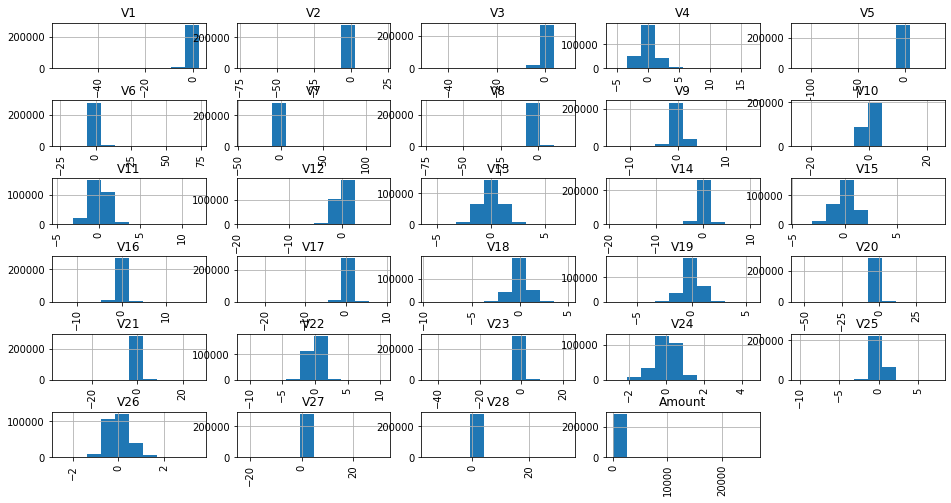

In [ ]:
fig = plt.figure(figsize=(16,8))
cols = 5

rows = np.ceil(float(X.shape[1]) / cols)
for i, column in enumerate(X.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    X[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

Наши данные сильно не сбалансированны

Построим матрицу корреляций, выбросим данные с единичной линейной зависимостью - они просто повысят вычислительную сложность модели.

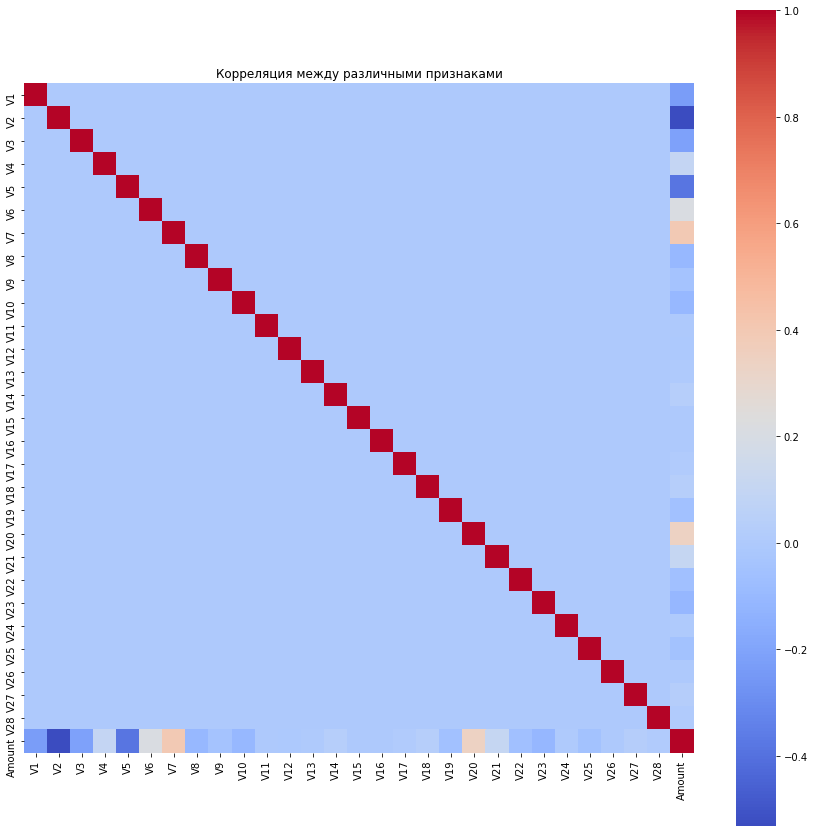

In [ ]:
correlation = X.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, square=True, cmap= 'coolwarm')
plt.title('Корреляция между различными признаками')
plt.show()

"Тепловая карта" позволяет сделать вывод об отсутствии "единичных" зависимостей и следовательно нет необходимости сокращаь наши данные.

Создадим обучающую выборку Х, переведем получанные цифровые данные в np.array

In [ ]:
X = np.array(X[X.columns])
X

array([[ 1.19308413e+00, -2.43758150e-01,  5.61957073e-01, ...,
        -6.87391287e-02, -7.45615755e-03,  3.71000000e+00],
       [-1.24021904e+00,  2.01339566e+00, -2.32125823e+00, ...,
         4.49315982e-01,  1.18062556e-01,  1.79000000e+00],
       [-1.96176660e+00,  3.46954783e+00, -1.50078330e+00, ...,
         1.17837953e+00, -4.65724092e-01,  9.36390000e+02],
       ...,
       [-6.66301761e-01,  8.93001642e-01,  1.29350107e+00, ...,
        -3.71818526e-02,  1.43869092e-01,  7.09000000e+01],
       [-7.23709115e-01,  1.01059789e+00,  7.35293646e-01, ...,
        -1.02270423e-01,  1.09922302e-01,  6.89000000e+01],
       [-5.30120966e-01,  8.90374920e-01,  1.81001632e+00, ...,
         1.94569878e-01, -9.72298037e-02,  1.00000000e+00]])

Т.к. изначально мы определили, что наши данные сильно разбросаны, нормализуем их

In [ ]:
from sklearn.preprocessing import scale
X_scaled = scale(np.array(X, dtype='float'), with_std=True, with_mean=True)
X_scaled

array([[ 0.60912278, -0.1476154 ,  0.37062239, ..., -0.17030157,
        -0.02258876, -0.33839649],
       [-0.63318726,  1.21927495, -1.53091815, ...,  1.11318285,
         0.3576757 , -0.34607282],
       [-1.00156954,  2.10109362, -0.98979784, ...,  2.91944185,
        -1.4109316 ,  3.39053854],
       ...,
       [-0.34017683,  0.54078518,  0.8530909 , ..., -0.09211825,
         0.43585774, -0.06976508],
       [-0.36948585,  0.61199928,  0.48494147, ..., -0.25337554,
         0.33301444, -0.07776125],
       [-0.27065045,  0.53919449,  1.19374346, ...,  0.48204796,
        -0.29456196, -0.34923131]])

Затем находим индексы в зависимости от метки класса и выбрасываем лишние.

In [ ]:
# np.argwhere вернет индексы тех элементов массива y (целевой переменной), где значение 0
not_churn_ids = np.argwhere(y == 0).flatten()
print('Всего не ушедших', len(not_churn_ids))
not_churn_ids

Всего не ушедших 284315


array([     0,      1,      2, ..., 284804, 284805, 284806])

Перемешаем массив с выбранным random state (чтоб в дальнейшем у нас совпадали выборки) выберем в нем "лишние" id тех, кто остались (кто портит нам прогноз алгоритма). Кол-во "лишних" = кол-во оставшихся - кол-во ушедшых.

In [ ]:
from sklearn.utils import shuffle

not_churn_ids = shuffle(not_churn_ids, random_state = 42)
not_churn_ids = not_churn_ids[len(np.argwhere(y == 1).flatten()):]
print(len(not_churn_ids))
not_churn_ids

283823


array([140128,  28821,  73328, ..., 132173, 147135, 122182])

Проверим, сбалансированны ли классы, (оставшиеся) - ("лишние") = (ушедшие)

In [ ]:
len(np.argwhere(y == 0).flatten()) - len(not_churn_ids) == len(np.argwhere(y == 1).flatten())

True

Удаляем "лишние" id из X и y

In [ ]:
# np.delete принимает массив, индексы, которые выбросить и по какой оси выкидывать
X = np.delete(X_scaled, not_churn_ids, 0)
y = np.delete(y, not_churn_ids, 0)

Выводим размеры наших выборок

In [ ]:
X.shape, y.shape

((984, 29), (984,))

Разбиваем наши выборки на обучающие и тестовые в соотношении 100/20 (они нам понадобятся в дальнейшем)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Инициализируем и попробуем построить три классические модели для решения нашей задачи (логистическая регрессия, случайный лес и метод ближайших сосоедей), затем отобразим построенные гиперплоскости полученные в ходе обучения наших моделей

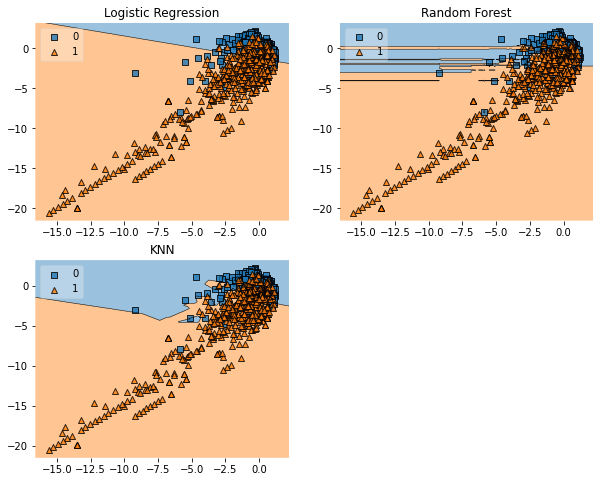

In [ ]:
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.plotting import plot_decision_regions

# Initializing Classifiers
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = KNeighborsClassifier(n_neighbors = 3)

X = X[:,[0, 2]]

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

for clf, lab, grd in zip([clf1, clf2, clf3],
                         ['Logistic Regression', 'Random Forest', 'KNN'],
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
plt.show()

Видим, что наши гиперплоскост построены не совсем корректно, поэтому попытаемся оптимизировать наши алгоритмы с помощью подбора классификаторов (мультикласс, OneVsOne - один против одного и OneVsRest - один против двух (в нашем случае)) и выведем значения предсказания наших моделей.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from numpy import mean


names = ["Logistic", "Random Forest", "KNN"]


classifiers = [
    LogisticRegression(random_state = 2, solver = 'lbfgs', max_iter = 5000, multi_class = 'auto'),
    RandomForestClassifier(max_depth=3, n_estimators=100, random_state = 2),
    KNeighborsClassifier(5)]

def train_clfs(classifiers, X, y):
    scoring = 'balanced_accuracy'
    scores_multi_val, scores_ovr_val, scores_ovo_val = [], [], []
    
    for model in classifiers:
        
        score = mean(cross_val_score(model, X, y, cv=5, scoring = scoring))
        scores_multi_val.append(score)
        
        score = mean(cross_val_score(OneVsRestClassifier(model), X, y, cv=5, scoring = scoring))
        scores_ovr_val.append(score)
        
        score = mean(cross_val_score(OneVsOneClassifier(model), X, y, cv=5, scoring = scoring))
        scores_ovo_val.append(score)
        
    scores_val = [scores_multi_val, scores_ovr_val, scores_ovo_val]
        
    return scores_val


# Обучение модели
scores_val = train_clfs(classifiers, X, y)


#Вывод результата
from IPython.display import display, HTML

print("Cross Validation Scores")
df_val = pd.DataFrame(scores_val, 
               columns =['LogReg', 'Random Forest','KNN']) 
df_val = df_val.set_index([pd.Index(['Multiclass', 'OneVsRest', 'OneVsOne'])])
display(df_val)

display(HTML(df.to_html()))

Cross Validation Scores


,LogReg,Random Forest,KNN
Multiclass,0.853597,0.86377,0.866832
OneVsRest,0.853597,0.86377,0.866832
OneVsOne,0.853597,0.50000,0.744888


Как видим найлучший результат показал KNN - 0.87, причем использование оптимизации OneVsOne явно ухудшает результат наших моделей

Для решения нашей задачи попробуем построить нейронню сеть MLPClassifier (Многослойный классификатор персептрона), которая оптимизирует функцию логарифмических потерь с помощью стохастического градиентного спуска. Задаем размер нейронного слоя - 200, адаптивную скороть обучения и максимальное количество итераций - 10000. Обучаем нашу модель и получаем значение предсказаний.

In [ ]:
from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

In [ ]:
MLPC = MLPClassifier(hidden_layer_sizes=(200,), learning_rate = 'adaptive', max_iter=10000)
MLPC.fit(X_train, y_train)
y_pred = MLPC.predict(X_test)
# Получаем значения recall
recall_acc = recall_score (y_test,y_pred)
print('Точность',recall_acc)

Точность 0.9270833333333334


Наша простейшая нейронная сеть показала наилучший результат обучения по выявлению аномальных операций клиентов

Посмотрим на метрики качества нашей нейросети через classification report

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       101
           1       0.96      0.93      0.94        96

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



Соотношение f1 имеет довольно хорошие значения